In [6]:
# %% [markdown]
# # Backtesting Framework for Multiple Strategies
# 
# This notebook implements a comprehensive backtesting framework for multiple trading strategies with sensitivity analysis.

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
from cso_lab.pricing import kirk_cso_price
from cso_lab.backtest import Backtest

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')  # Updated style name for newer matplotlib
except:
    plt.style.use('ggplot')  # Fallback style
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set random seed for reproducibility
np.random.seed(42)

# Define paths
PROJECT_ROOT = Path.cwd().parent  # Go up one level from current working directory
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_BASE = DATA_DIR / "outputs"
SYNTHETIC_DIR = DATA_DIR / "synthetic"

In [7]:
# %% [markdown]
# ## 1. Data Loading and Preparation
# 
# First, let's load the synthetic data and calculate theoretical prices.

# %%


def load_synthetic_data():
    files = {
        "spot": "spot_series.csv",
        "hh_fut": "hh_futures_curves.csv",
        "wti_fut": "wti_futures_curves.csv",
        "corr": "correlation.csv",
        "vol_hh": "vol_surface_hh.csv",
        "vol_wti": "vol_surface_wti.csv",
        "cso_chain": "cso_chain.csv"
    }
    return {name: pd.read_csv(SYNTHETIC_DIR / fname) for name, fname in files.items()}


def calculate_kirk_prices(cso_chain, vol_hh, vol_wti, rho=0.4):
    """Calculate theoretical prices using Kirk's approximation."""
    prices = []
    for _, row in cso_chain.iterrows():
        F1 = row['F1']  # HH forward
        F2 = row['F2']  # WTI forward
        K = row['strike']
        T = row['tenor']
        
        sigma1 = row['vol1']
        sigma2 = row['vol2']
        rho = row['rho']
        price = kirk_cso_price(F1, F2, K, sigma1, sigma2, rho, T)
        prices.append(price)
    
    return pd.Series(prices, index=cso_chain.index)

In [3]:


# %% [markdown]
# ## 2. Backtesting Functions
# 
# Let's define the core backtesting functions.

# %%
def run_backtest(market_prices, theoretical_prices, z_score_threshold=1.0, transaction_costs=0.001):
    """Run backtest with given parameters."""
    backtest = Backtest(
        prices=market_prices,
        fair_values=theoretical_prices
    )
    
    pnl, stats = backtest.run(
        z_score_threshold=z_score_threshold,
        transaction_costs=transaction_costs
    )
    
    return backtest, pnl, stats

def save_backtest_results(backtest, pnl_series, stats_dict, strategy_name, output_base=OUTPUT_BASE):
    """Save backtest results and generate plots."""
    # Directory setup
    output_path = output_base / strategy_name
    plots_dir = output_path / 'plots'
    sensitivity_dir = output_path / 'sensitivity'
    
    for directory in [output_path, plots_dir, sensitivity_dir]:
        directory.mkdir(parents=True, exist_ok=True)
    
    # Save PnL data
    pnl_df = pd.DataFrame({
        'date': pnl_series.index,
        'pnl': pnl_series.values,
        'cumulative_pnl': pnl_series.cumsum().values,
        'position': backtest.positions.values
    })
    pnl_file = output_path / 'backtest_pnl.csv'
    pnl_df.to_csv(pnl_file, index=False)
    
    # Save statistics
    stats_file = output_path / 'backtest_stats.txt'
    with open(stats_file, 'w') as f:
        f.write(f"Backtest Performance - {strategy_name}\n")
        f.write("=" * 50 + "\n")
        for key, value in stats_dict.items():
            formatted_key = key.replace('_', ' ').title()
            if any(x in key for x in ['pct', 'ratio', 'rate']):
                f.write(f"{formatted_key}: {value:.4f}\n")
            elif 'drawdown' in key:
                f.write(f"{formatted_key}: {value*100:.2f}%\n")
            else:
                f.write(f"{formatted_key}: {value}\n")
    
    # Generate and save plots
    _generate_plots(backtest, pnl_series, plots_dir, strategy_name)
    
    print(f"✓ Results saved to: {output_path}")

def _generate_plots(backtest, pnl_series, plots_dir, strategy_name):
    """Generate and save all backtest plots."""
    # 1. Cumulative PnL
    plt.figure(figsize=(14, 6))
    (pnl_series.cumsum()).plot(title=f'Cumulative PnL - {strategy_name}', 
                              color='blue', linewidth=2, grid=True)
    plt.axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig(plots_dir / 'cumulative_pnl.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Drawdown
    plt.figure(figsize=(14, 4))
    returns = pnl_series / backtest.prices.shift(1)
    returns = returns.replace([np.inf, -np.inf], np.nan).dropna()
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.expanding(min_periods=1).max()
    drawdown = (cum_returns - peak) / peak
    drawdown.plot(title=f'Drawdown - {strategy_name}', 
                 color='red', linewidth=1.5, grid=True)
    plt.fill_between(drawdown.index, drawdown.values, 0, 
                    where=(drawdown < 0), color='red', alpha=0.3)
    plt.tight_layout()
    plt.savefig(plots_dir / 'drawdown.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. PnL Histogram
    plt.figure(figsize=(12, 6))
    plt.hist(pnl_series.dropna(), bins=50, color='skyblue', 
             edgecolor='black', alpha=0.7)
    plt.title(f'Daily PnL Distribution - {strategy_name}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(plots_dir / 'pnl_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Price Chart with Trades
    plt.figure(figsize=(14, 8))
    ax1 = plt.gca()
    ax1.plot(backtest.prices, label='Market Price', color='black', linewidth=1.5)
    if hasattr(backtest, 'fair_values'):
        ax1.plot(backtest.fair_values, label='Theoretical Price', 
                color='blue', alpha=0.7, linewidth=1.2)
    
    positions = backtest.positions
    long_entries = positions[positions == 1].index
    short_entries = positions[positions == -1].index
    
    ax1.scatter(long_entries, backtest.prices[long_entries], 
               marker='^', color='green', label='Long Entry', s=100, zorder=5)
    ax1.scatter(short_entries, backtest.prices[short_entries], 
               marker='v', color='red', label='Short Entry', s=100, zorder=5)
    
    ax2 = ax1.twinx()
    ax2.plot(pnl_series.cumsum(), label='Cumulative PnL', 
            color='purple', alpha=0.7, linewidth=1.5)
    
    ax1.set_title(f'Price Chart with Trades - {strategy_name}')
    ax1.grid(True, alpha=0.3)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    plt.tight_layout()
    plt.savefig(plots_dir / 'price_chart_with_trades.png', dpi=300, bbox_inches='tight')
    plt.show()

In [4]:

# %% [markdown]
# ## 3. Sensitivity Analysis
# 
# Let's implement the sensitivity analysis to evaluate how different parameters affect strategy performance.

# %%
def run_parameter_sensitivity(market_series, theoretical_series, strategy_name,
                            z_scores=None, costs=None, n_simulations=3):
    """Run and save sensitivity analysis for a strategy."""
    if z_scores is None:
        z_scores = np.linspace(0.5, 2.5, 5)
    if costs is None:
        costs = [0.0005, 0.001, 0.002, 0.005]
    
    sensitivity_results = []
    
    for z in z_scores:
        for c in costs:
            sharpe_ratios = []
            for _ in range(n_simulations):
                noise = np.random.normal(0, 0.01, len(market_series))
                noisy_market = market_series * (1 + noise)
                
                bt = Backtest(prices=noisy_market, fair_values=theoretical_series)
                pnl, stats = bt.run(z_score_threshold=z, transaction_costs=c)
                sharpe_ratios.append(stats['sharpe_ratio'])
            
            median_sharpe = np.median(sharpe_ratios)
            bt = Backtest(prices=market_series, fair_values=theoretical_series)
            pnl, stats = bt.run(z_score_threshold=z, transaction_costs=c)
            
            sensitivity_results.append({
                'z_score': z,
                'cost': c,
                'sharpe': median_sharpe,
                'total_return': stats['total_return'],
                'max_drawdown': stats['max_drawdown'],
                'win_rate': stats.get('win_rate', 0),
                'num_trades': stats['num_trades']
            })
            print(f"z={z:.2f}, cost={c:.4f} => Sharpe={median_sharpe:.2f}")
    
    sensitivity_df = pd.DataFrame(sensitivity_results)
    output_dir = OUTPUT_BASE / strategy_name / 'sensitivity'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save results
    sensitivity_df.to_csv(output_dir / 'sensitivity_results.csv', index=False)
    _plot_sensitivity(sensitivity_df, output_dir, strategy_name)
    
    return sensitivity_df

def _plot_sensitivity(sensitivity_df, output_dir, strategy_name):
    """Generate and save sensitivity plots."""
    # Create figure and axes
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle(f'Sensitivity Analysis - {strategy_name}', fontsize=16)

    # 1. Sharpe Ratio Heatmap
    pivot_sharpe = sensitivity_df.pivot(index='z_score', columns='cost', values='sharpe')
    sns.heatmap(pivot_sharpe, annot=True, fmt='.2f', cmap='viridis', ax=axes[0, 0])
    axes[0, 0].set_title('Sharpe Ratio')
    
    # 2. Total Return Heatmap
    pivot_return = sensitivity_df.pivot(index='z_score', columns='cost', values='total_return')
    sns.heatmap(pivot_return, annot=True, fmt='.0f', cmap='YlGn', ax=axes[0, 1])
    axes[0, 1].set_title('Total Return')
    
    # 3. Max Drawdown Heatmap
    pivot_dd = sensitivity_df.pivot(index='z_score', columns='cost', values='max_drawdown') * 100
    sns.heatmap(pivot_dd, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1, 0])
    axes[1, 0].set_title('Max Drawdown (%)')
    
    # 4. Win Rate Heatmap
    pivot_win = sensitivity_df.pivot(index='z_score', columns='cost', values='win_rate') * 100
    sns.heatmap(pivot_win, annot=True, fmt='.1f', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_title('Win Rate (%)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig(output_dir / 'sensitivity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


In [9]:
# Load data once
print("Loading data...")
data = load_synthetic_data()
cso_chain = data['cso_chain']

# Theoretical prices
print("Calculating theoretical prices...")
theoretical_prices = calculate_kirk_prices(cso_chain, 0.6, 0.3)
market_prices = cso_chain['price']

# Convert to time series with dates
dates = pd.date_range(start='2023-01-01', periods=len(cso_chain), freq='D')
market_series = pd.Series(market_prices.values, index=dates, name='market_price')
theoretical_series = pd.Series(theoretical_prices.values, index=dates, name='theoretical_price')

print("Data ready")


Loading data...
Calculating theoretical prices...
Data ready


In [10]:
def run_single_strategy(strategy_name, z_score, cost):
    print("=" * 80)
    print(f"Running {strategy_name}...")
    print("=" * 80)
    
    try:
        bt, pnl, stats = run_backtest(
            market_series,
            theoretical_series,
            z_score_threshold=z_score,
            transaction_costs=cost
        )
        
        # Save results and plots
        save_backtest_results(bt, pnl, stats, strategy_name)
        
        # Run sensitivity analysis
        print(f"Running sensitivity analysis for {strategy_name}...")
        run_parameter_sensitivity(
            market_series,
            theoretical_series,
            strategy_name
        )
        
        print(f"Completed {strategy_name}")
        return stats
    
    except Exception as e:
        print(f"Error in {strategy_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


Running strategy1_relative_value...


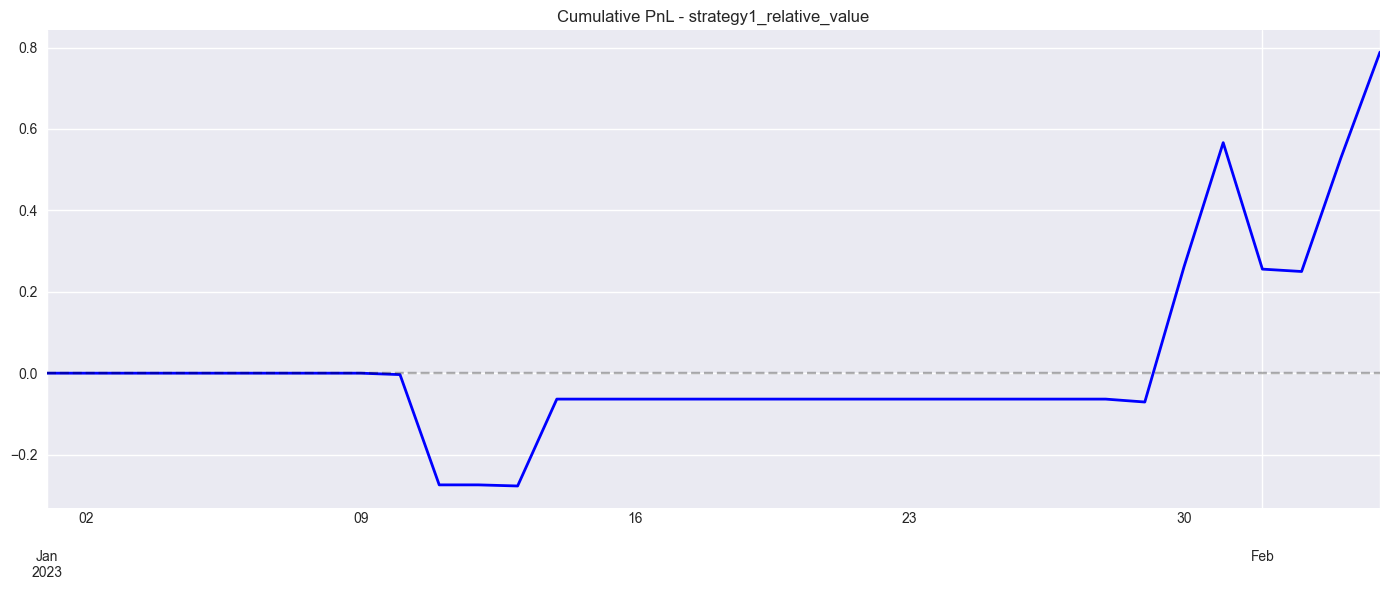

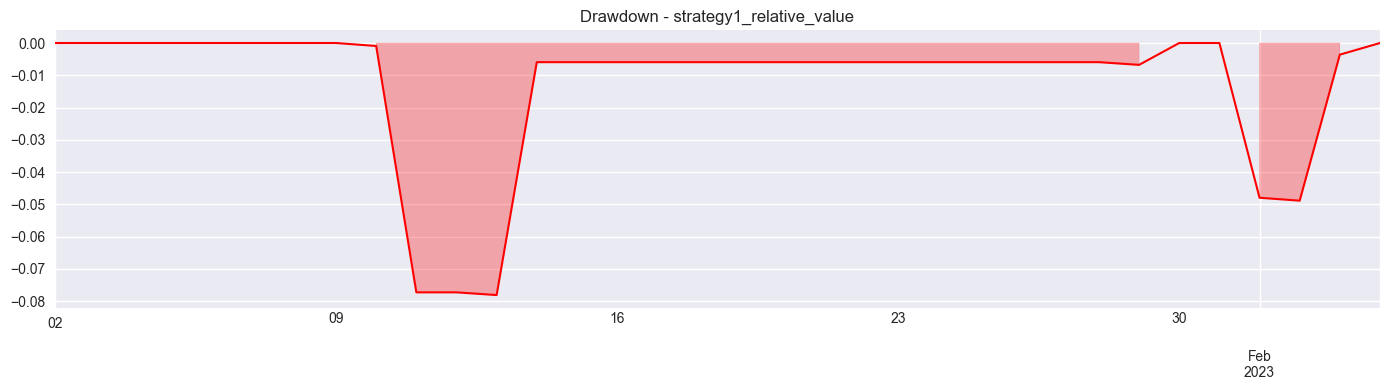

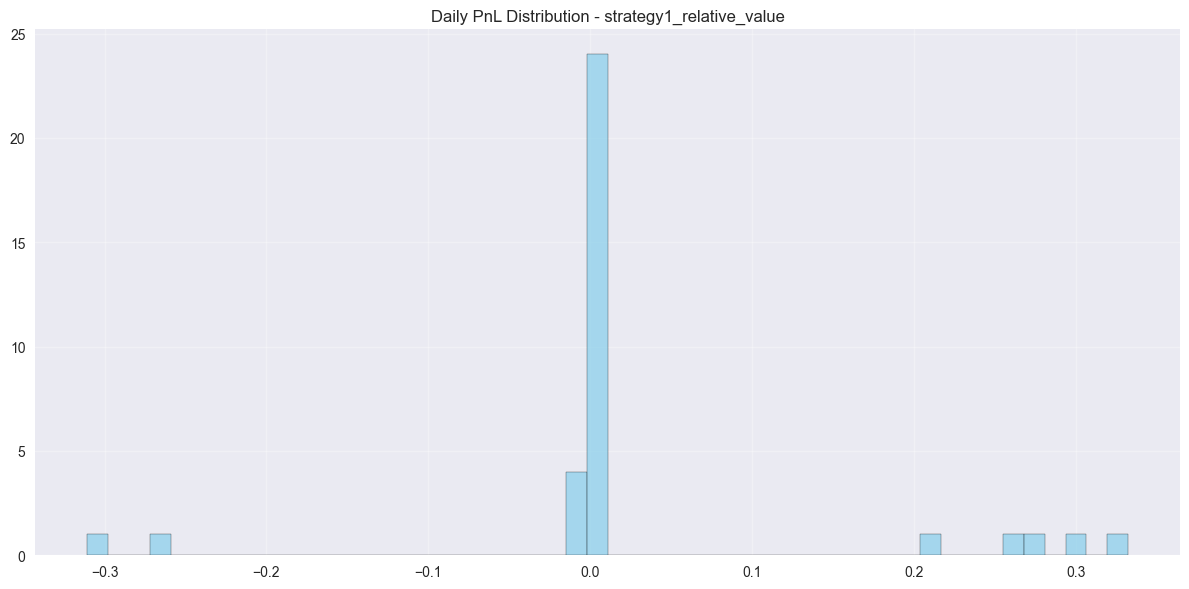

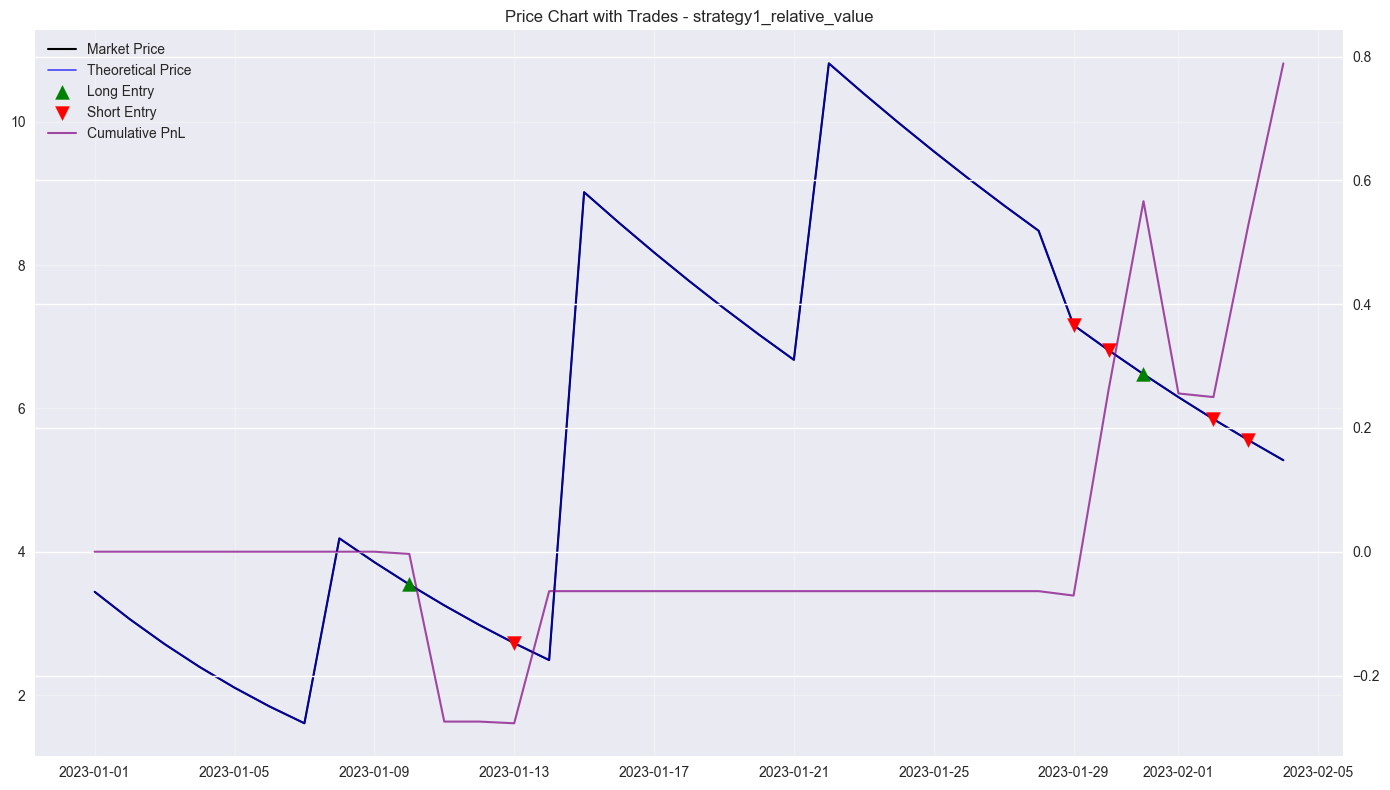

✓ Results saved to: /Users/amankesarwani/PycharmProjects/cso-lab/data/outputs/strategy1_relative_value
Running sensitivity analysis for strategy1_relative_value...
z=0.50, cost=0.0005 => Sharpe=2.51
z=0.50, cost=0.0010 => Sharpe=3.11
z=0.50, cost=0.0020 => Sharpe=-2.38
z=0.50, cost=0.0050 => Sharpe=2.22
z=1.00, cost=0.0005 => Sharpe=3.08
z=1.00, cost=0.0010 => Sharpe=-0.74
z=1.00, cost=0.0020 => Sharpe=2.72
z=1.00, cost=0.0050 => Sharpe=2.87
z=1.50, cost=0.0005 => Sharpe=0.49
z=1.50, cost=0.0010 => Sharpe=2.81
z=1.50, cost=0.0020 => Sharpe=0.40
z=1.50, cost=0.0050 => Sharpe=-0.14
z=2.00, cost=0.0005 => Sharpe=-2.83
z=2.00, cost=0.0010 => Sharpe=1.63
z=2.00, cost=0.0020 => Sharpe=0.30
z=2.00, cost=0.0050 => Sharpe=-0.98
z=2.50, cost=0.0005 => Sharpe=-2.83
z=2.50, cost=0.0010 => Sharpe=1.41
z=2.50, cost=0.0020 => Sharpe=-2.73
z=2.50, cost=0.0050 => Sharpe=0.00


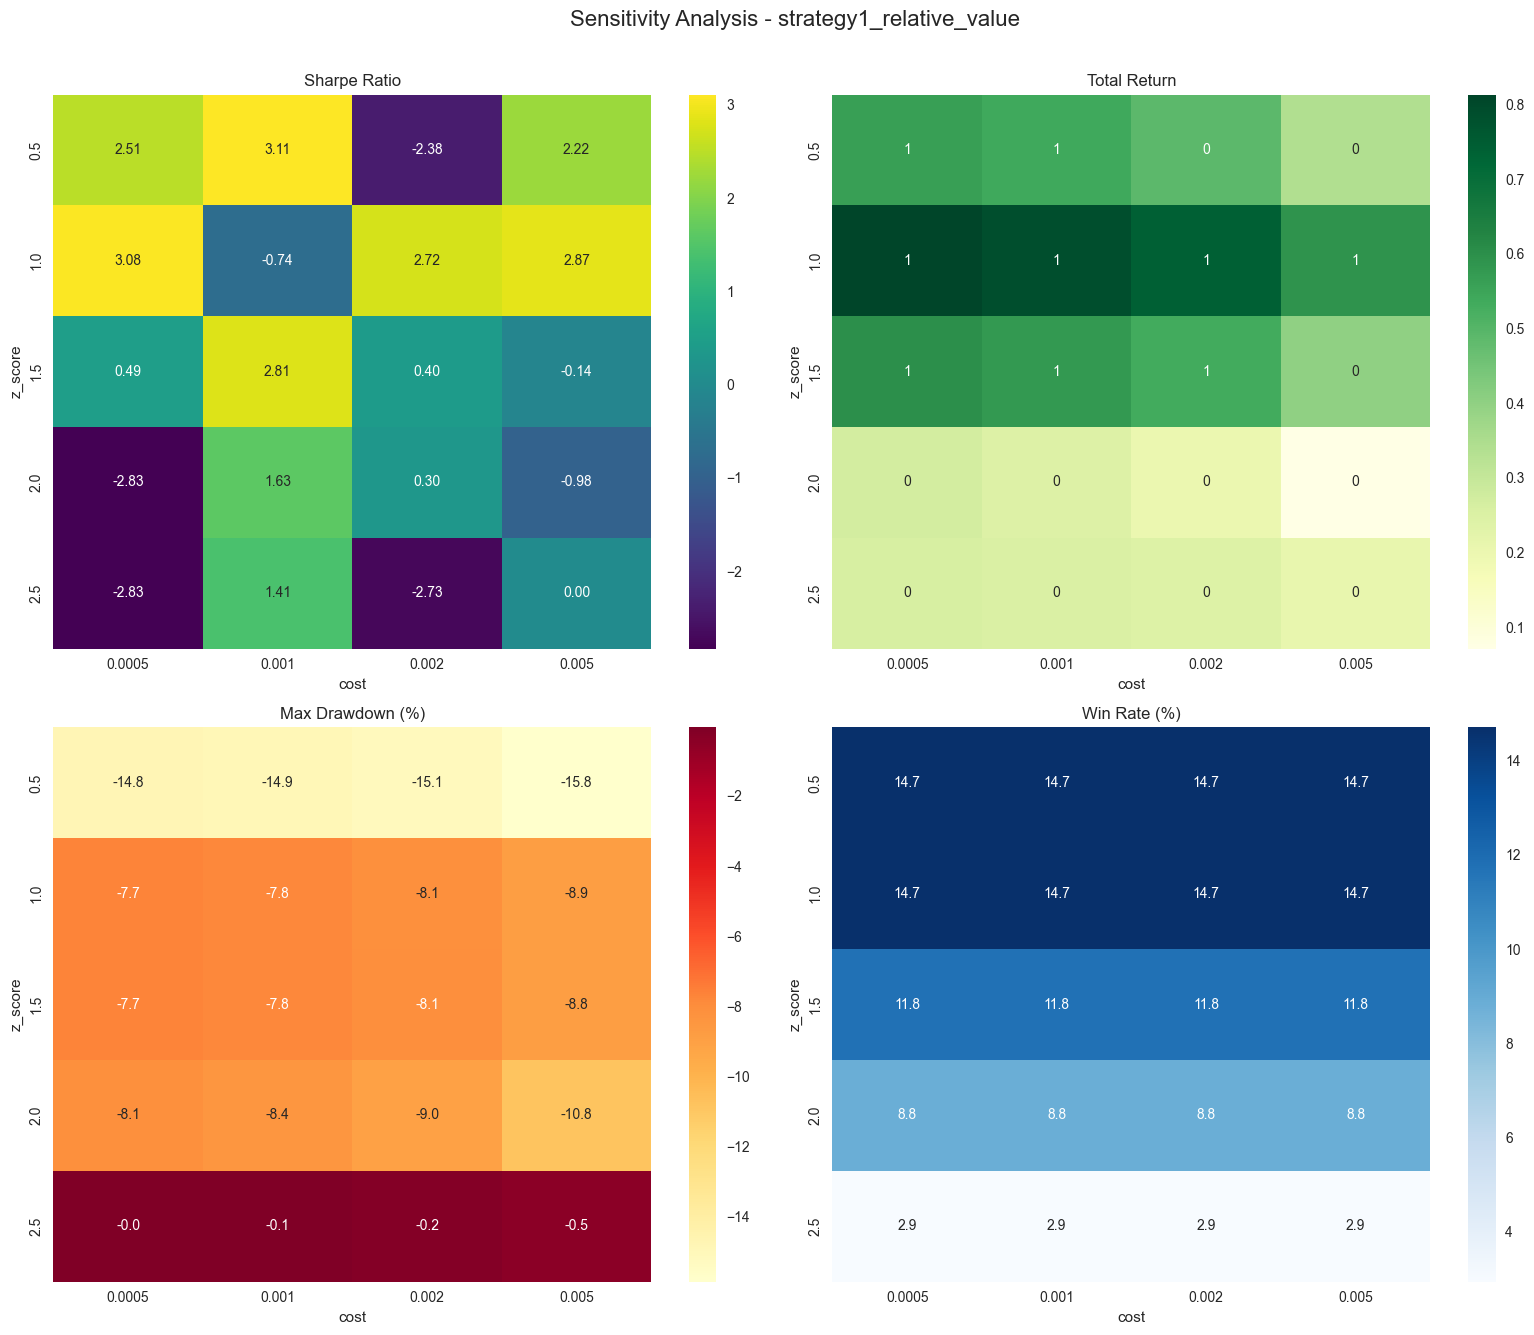

Completed strategy1_relative_value


{'total_return': 0.78886714863825,
 'total_return_pct': 22.91541717774966,
 'annualized_return': 1.0074003794213144,
 'annualized_vol': 0.4131149539942211,
 'sharpe_ratio': 2.438547357536243,
 'max_drawdown': -0.07811370642360227,
 'win_rate': 0.14705882352941177,
 'profit_factor': 2.0618184381575078,
 'num_trades': 4}

In [11]:
stats1 = run_single_strategy(
    strategy_name="strategy1_relative_value",
    z_score=1.0,
    cost=0.001
)
stats1


Running strategy2_technical...


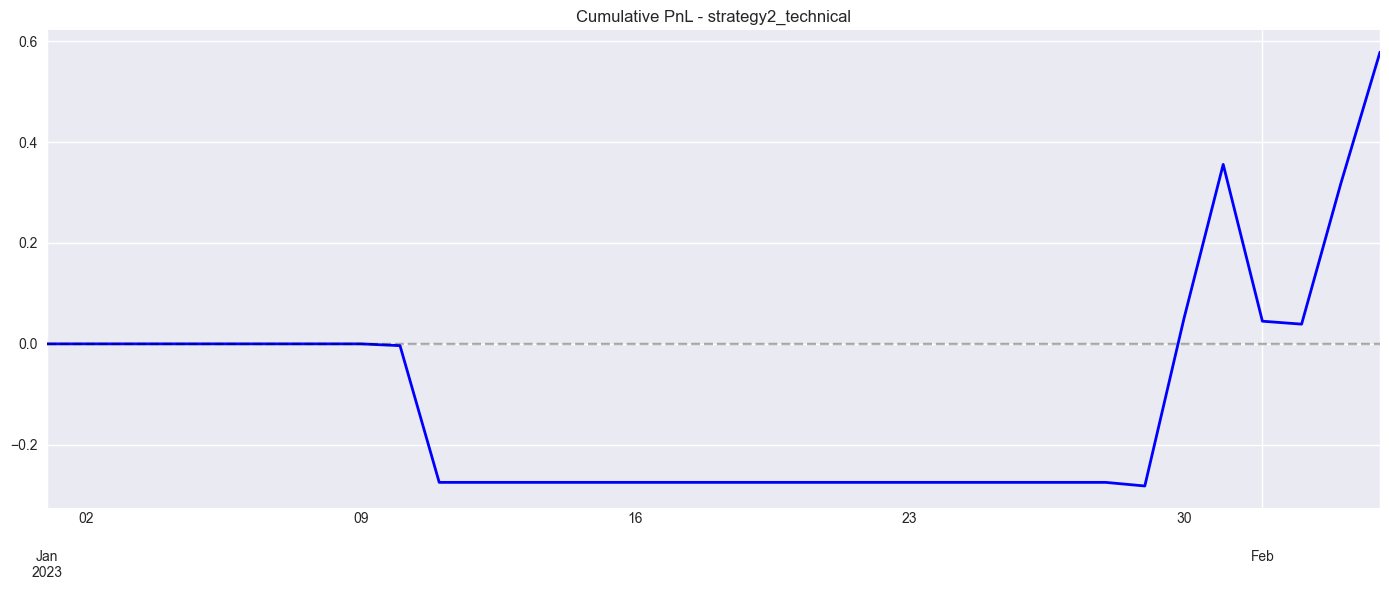

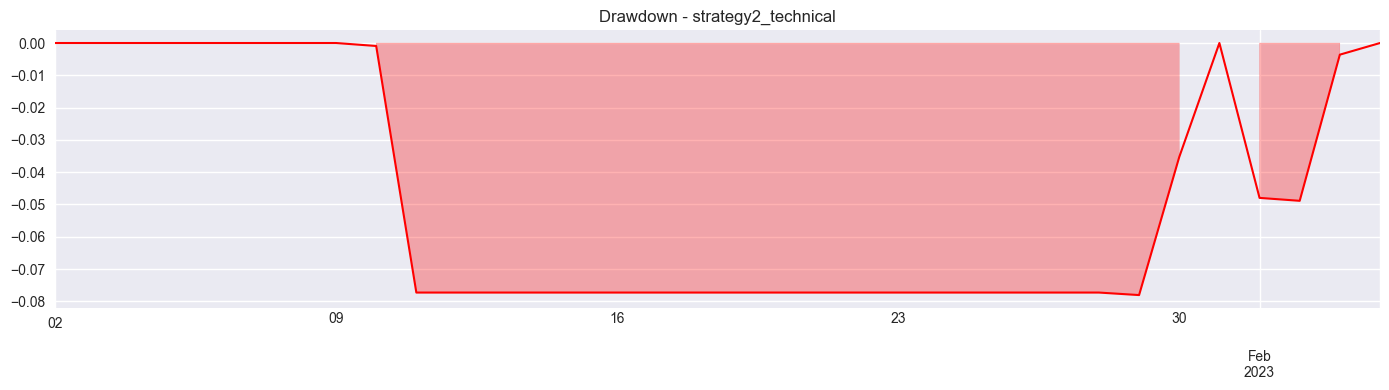

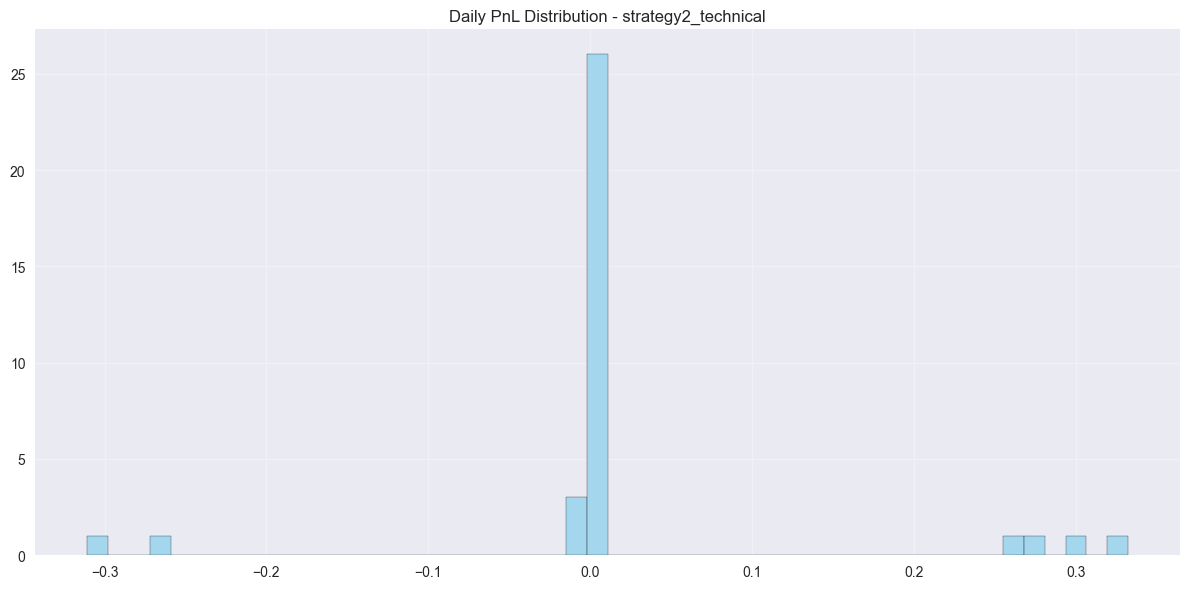

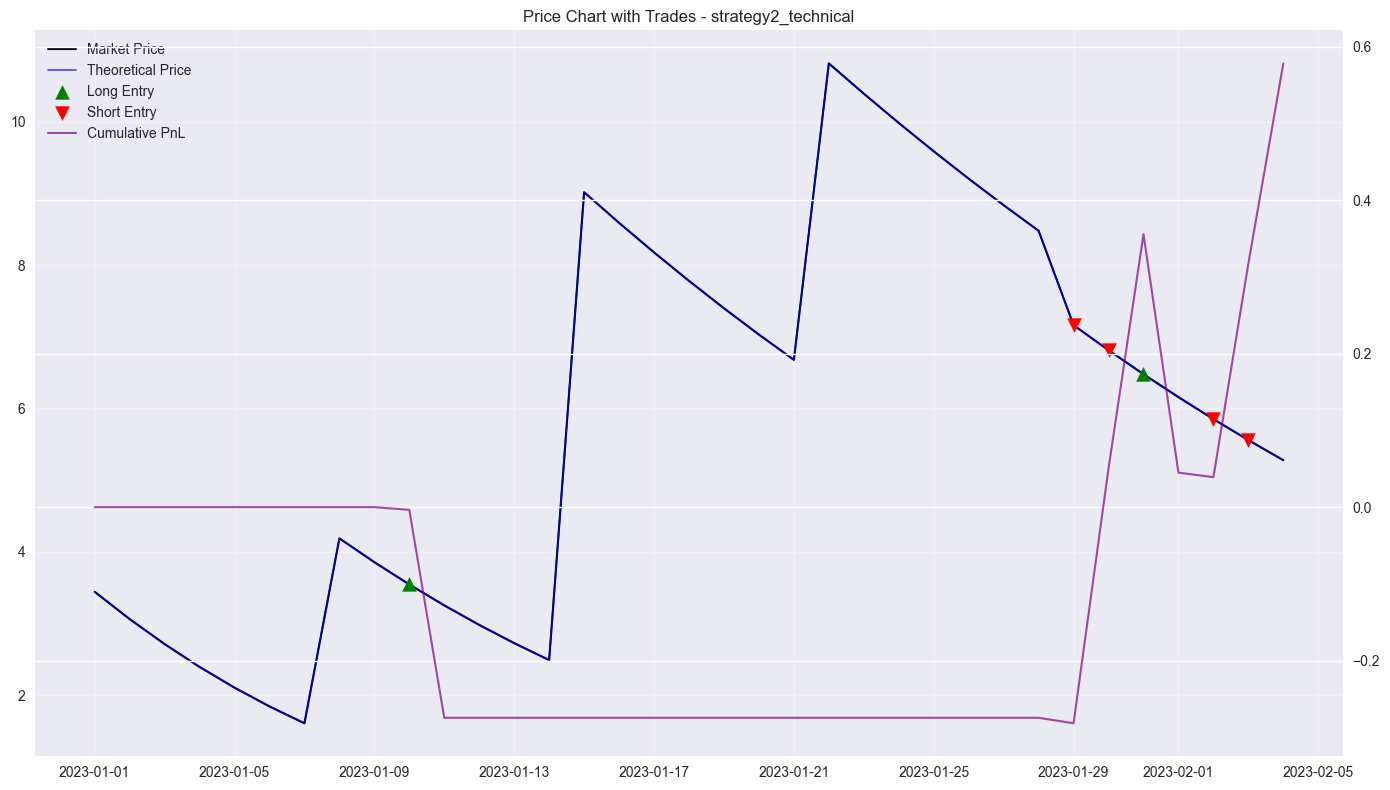

✓ Results saved to: /Users/amankesarwani/PycharmProjects/cso-lab/data/outputs/strategy2_technical
Running sensitivity analysis for strategy2_technical...
z=0.50, cost=0.0005 => Sharpe=2.81
z=0.50, cost=0.0010 => Sharpe=-2.40
z=0.50, cost=0.0020 => Sharpe=-2.40
z=0.50, cost=0.0050 => Sharpe=-1.94
z=1.00, cost=0.0005 => Sharpe=4.01
z=1.00, cost=0.0010 => Sharpe=-2.51
z=1.00, cost=0.0020 => Sharpe=3.65
z=1.00, cost=0.0050 => Sharpe=-2.30
z=1.50, cost=0.0005 => Sharpe=-0.11
z=1.50, cost=0.0010 => Sharpe=-2.61
z=1.50, cost=0.0020 => Sharpe=2.35
z=1.50, cost=0.0050 => Sharpe=0.93
z=2.00, cost=0.0005 => Sharpe=0.09
z=2.00, cost=0.0010 => Sharpe=0.70
z=2.00, cost=0.0020 => Sharpe=1.83
z=2.00, cost=0.0050 => Sharpe=-0.71
z=2.50, cost=0.0005 => Sharpe=2.69
z=2.50, cost=0.0010 => Sharpe=1.79
z=2.50, cost=0.0020 => Sharpe=-2.86
z=2.50, cost=0.0050 => Sharpe=2.39


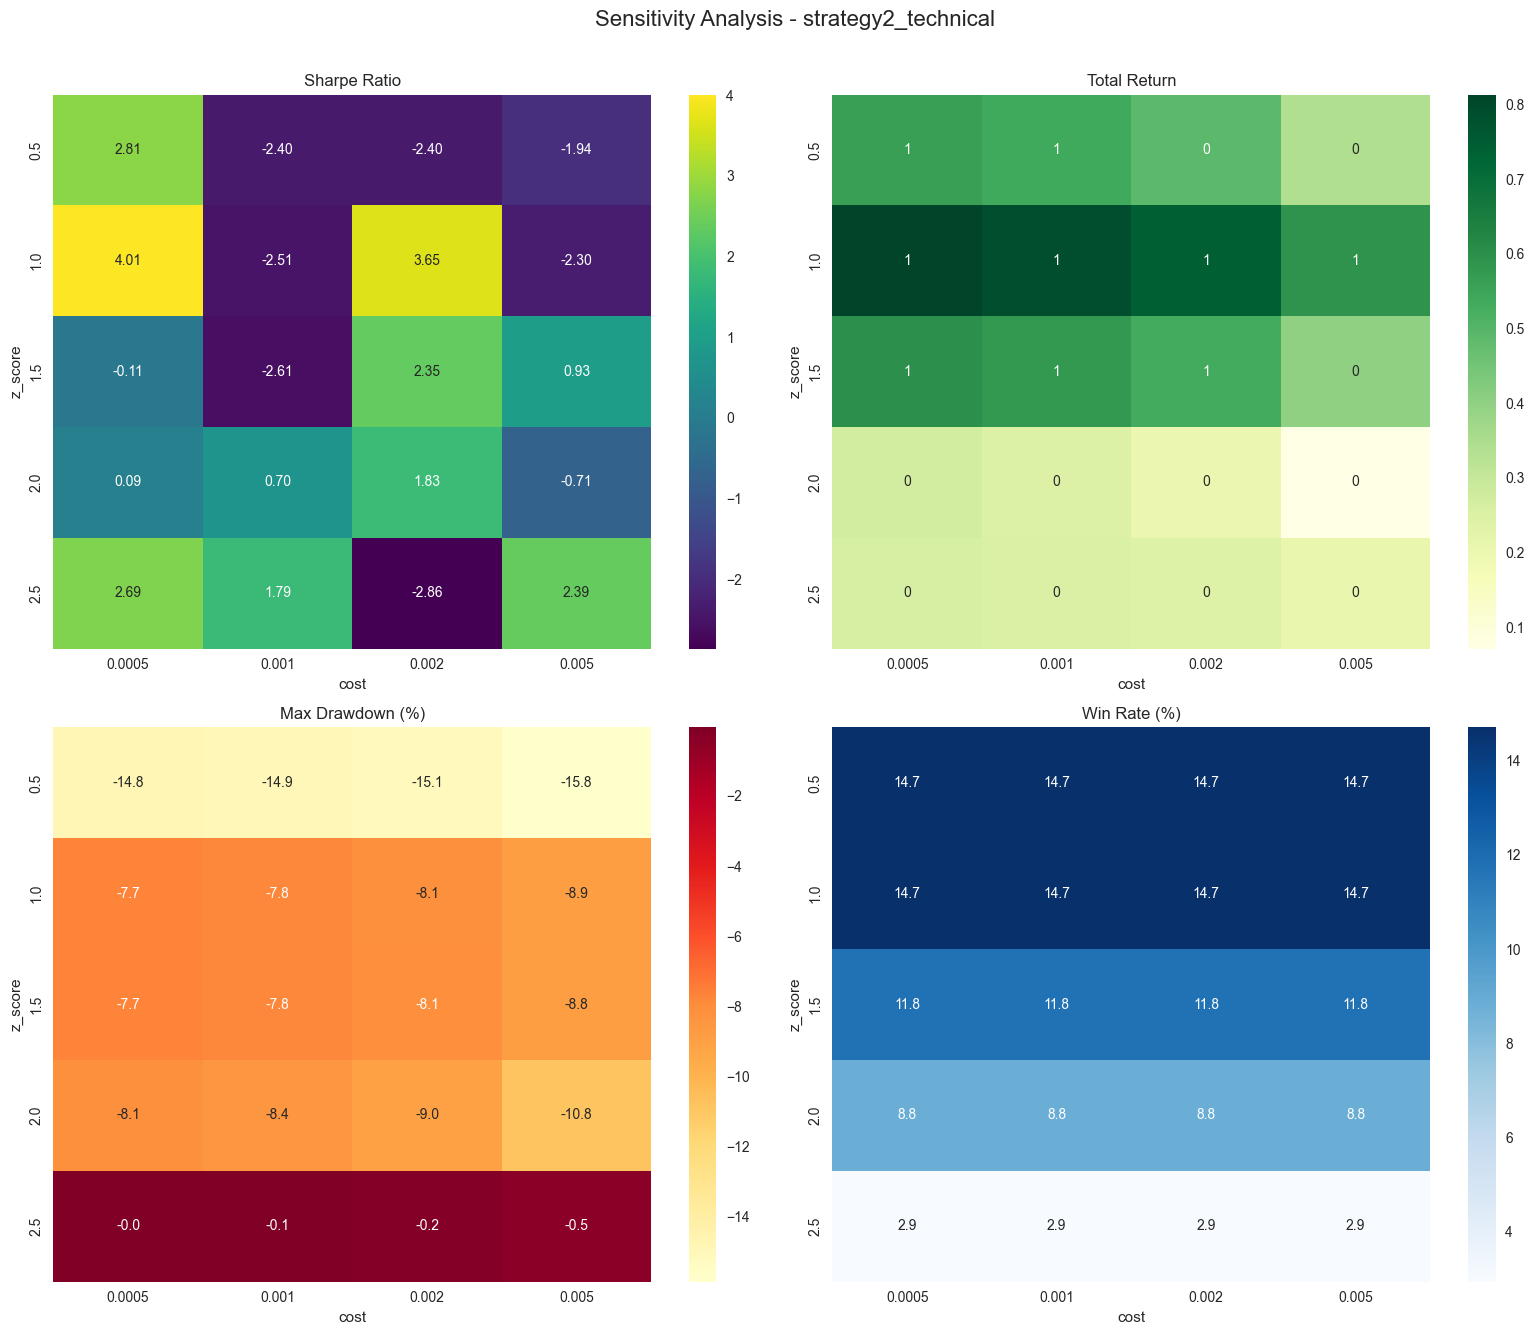

Completed strategy2_technical


{'total_return': 0.5781287363142732,
 'total_return_pct': 16.79377978656575,
 'annualized_return': 0.4338748904411658,
 'annualized_vol': 0.35668649648744416,
 'sharpe_ratio': 1.2164040262635476,
 'max_drawdown': -0.07804907061402544,
 'win_rate': 0.11764705882352941,
 'profit_factor': 1.460603546223171,
 'num_trades': 3}

In [12]:
stats2 = run_single_strategy(
    strategy_name="strategy2_technical",
    z_score=1.5,
    cost=0.001
)
stats2


Running strategy3_momentum...


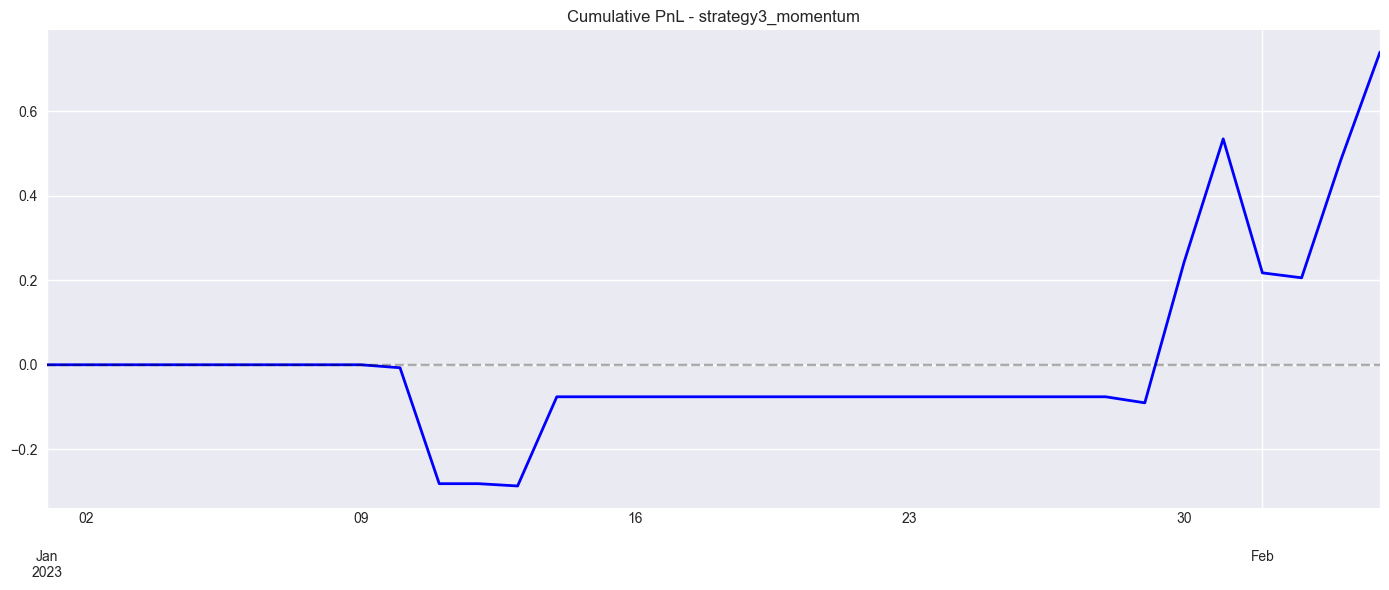

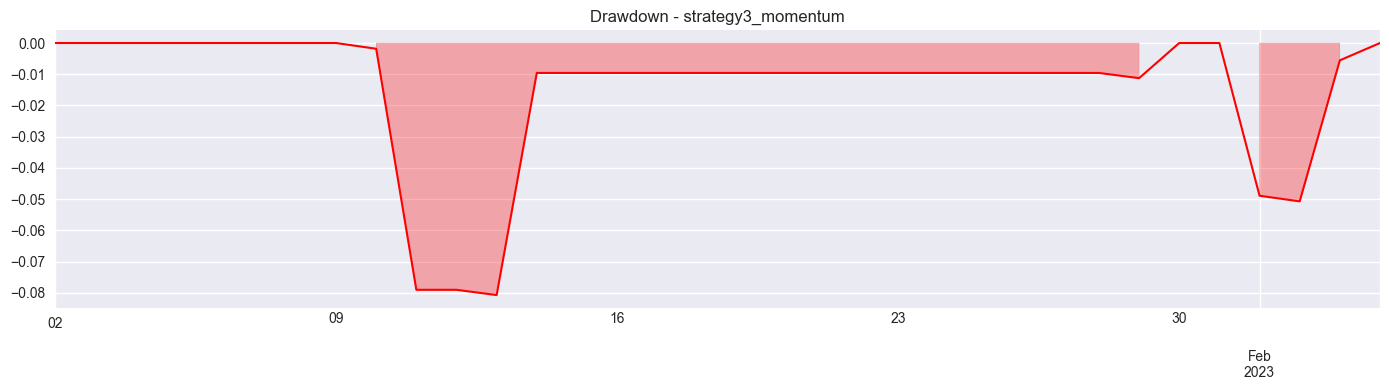

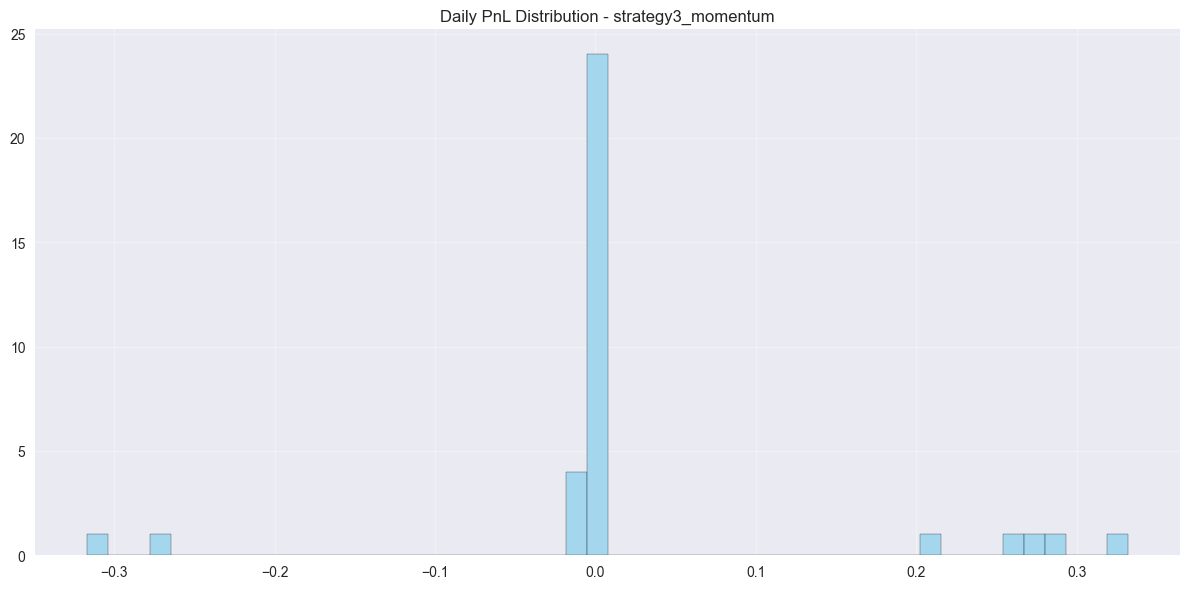

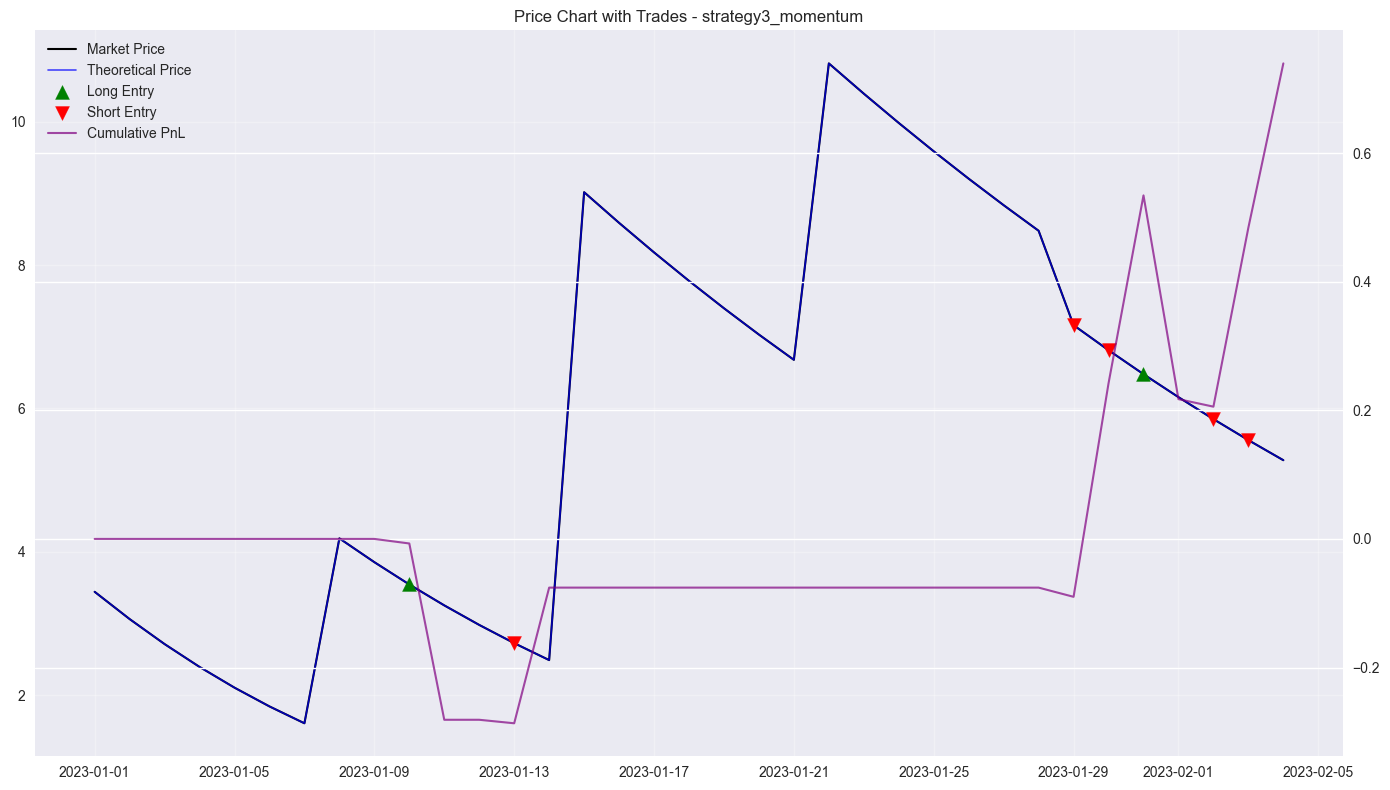

✓ Results saved to: /Users/amankesarwani/PycharmProjects/cso-lab/data/outputs/strategy3_momentum
Running sensitivity analysis for strategy3_momentum...
z=0.50, cost=0.0005 => Sharpe=2.42
z=0.50, cost=0.0010 => Sharpe=-2.42
z=0.50, cost=0.0020 => Sharpe=-2.75
z=0.50, cost=0.0050 => Sharpe=-2.42
z=1.00, cost=0.0005 => Sharpe=2.47
z=1.00, cost=0.0010 => Sharpe=2.99
z=1.00, cost=0.0020 => Sharpe=2.72
z=1.00, cost=0.0050 => Sharpe=-1.31
z=1.50, cost=0.0005 => Sharpe=0.16
z=1.50, cost=0.0010 => Sharpe=0.17
z=1.50, cost=0.0020 => Sharpe=2.49
z=1.50, cost=0.0050 => Sharpe=-0.86
z=2.00, cost=0.0005 => Sharpe=1.69
z=2.00, cost=0.0010 => Sharpe=0.86
z=2.00, cost=0.0020 => Sharpe=1.36
z=2.00, cost=0.0050 => Sharpe=-1.33
z=2.50, cost=0.0005 => Sharpe=0.53
z=2.50, cost=0.0010 => Sharpe=0.00
z=2.50, cost=0.0020 => Sharpe=-3.26
z=2.50, cost=0.0050 => Sharpe=2.97


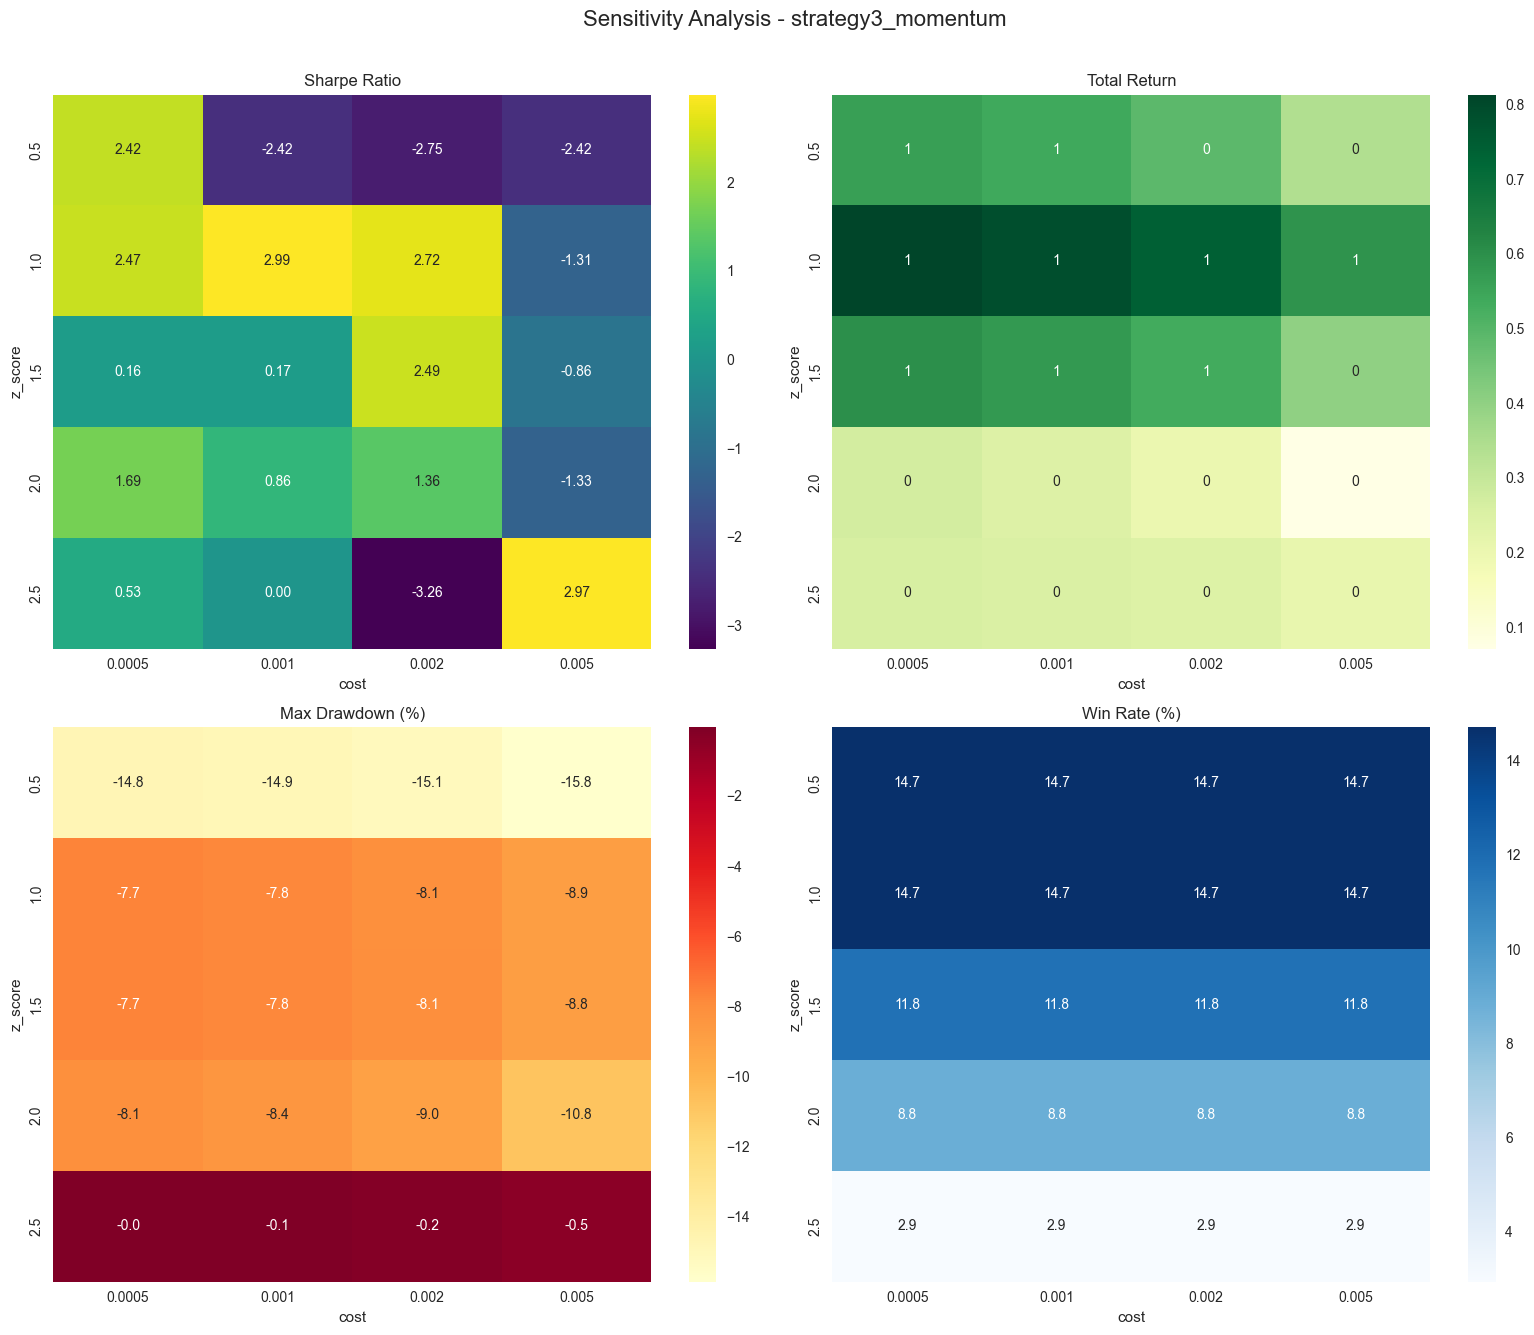

Completed strategy3_momentum


{'total_return': 0.7394476707840683,
 'total_return_pct': 21.479854860710585,
 'annualized_return': 0.9387537201253832,
 'annualized_vol': 0.41235190797676513,
 'sharpe_ratio': 2.2765839128317538,
 'max_drawdown': -0.08071958039817939,
 'win_rate': 0.14705882352941177,
 'profit_factor': 1.9487210993306927,
 'num_trades': 4}

In [13]:
stats3 = run_single_strategy(
    strategy_name="strategy3_momentum",
    z_score=1.0,
    cost=0.002
)
stats3


Running strategy4_breakout...


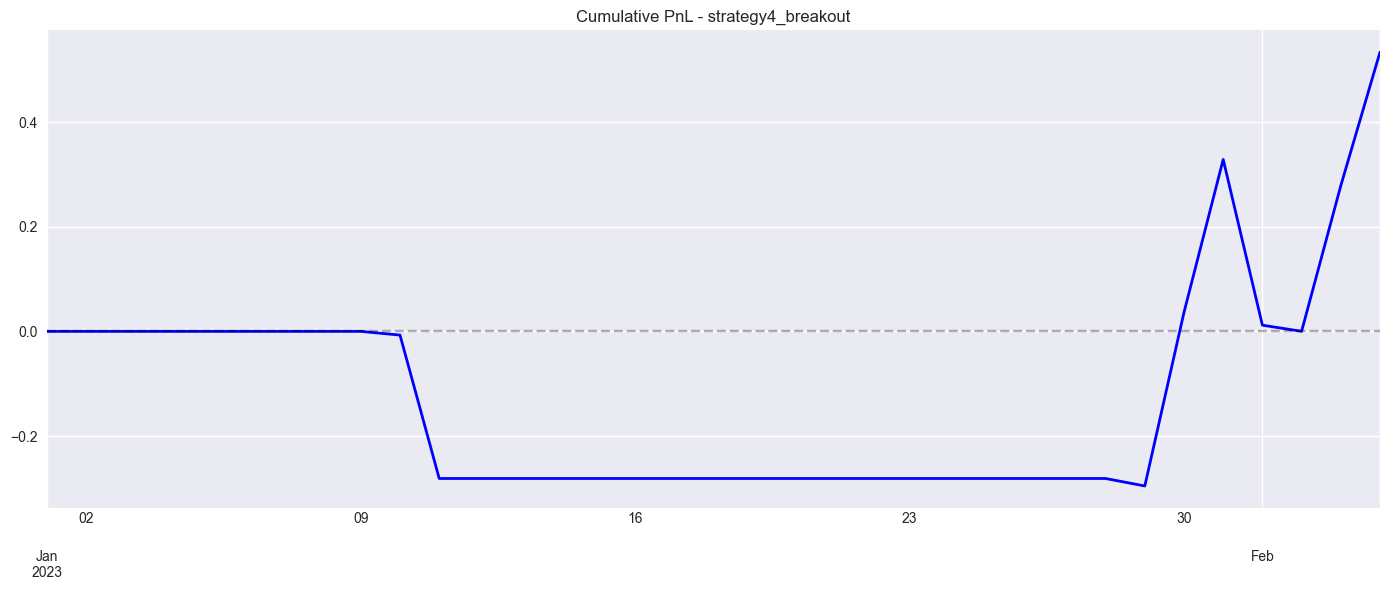

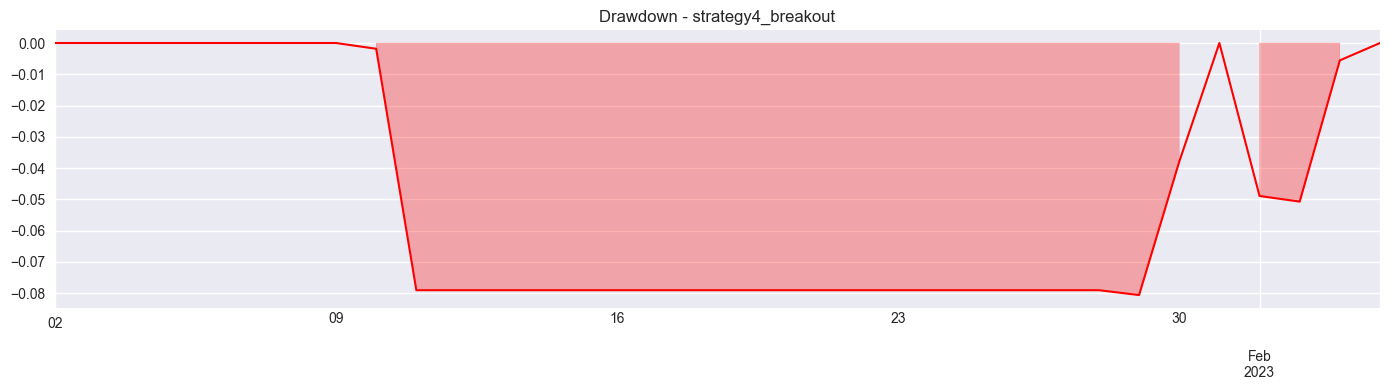

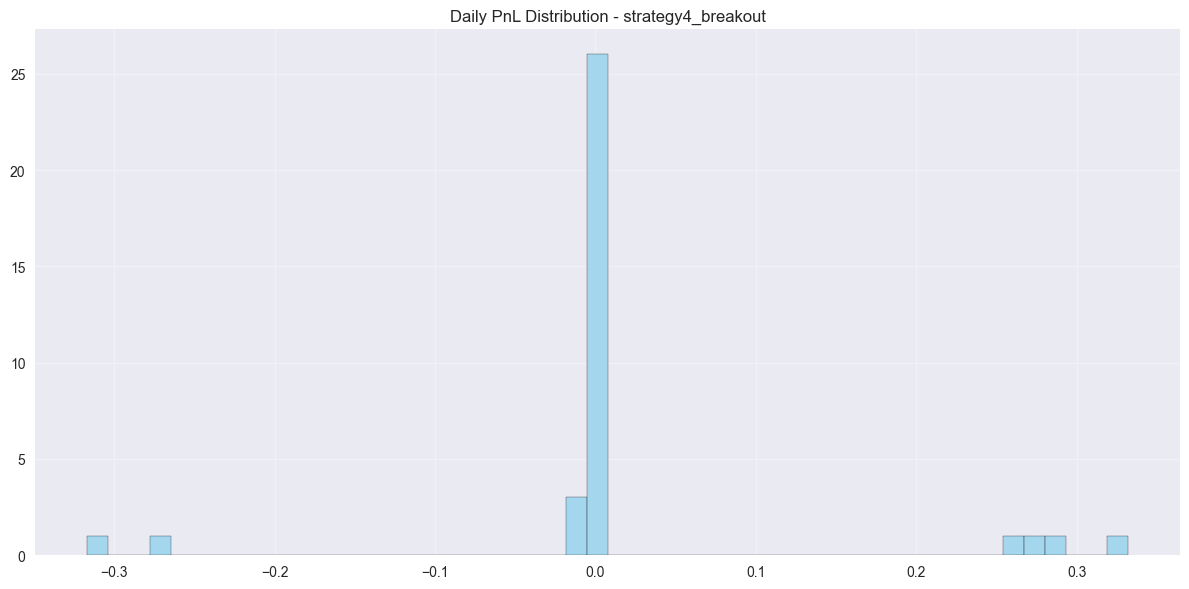

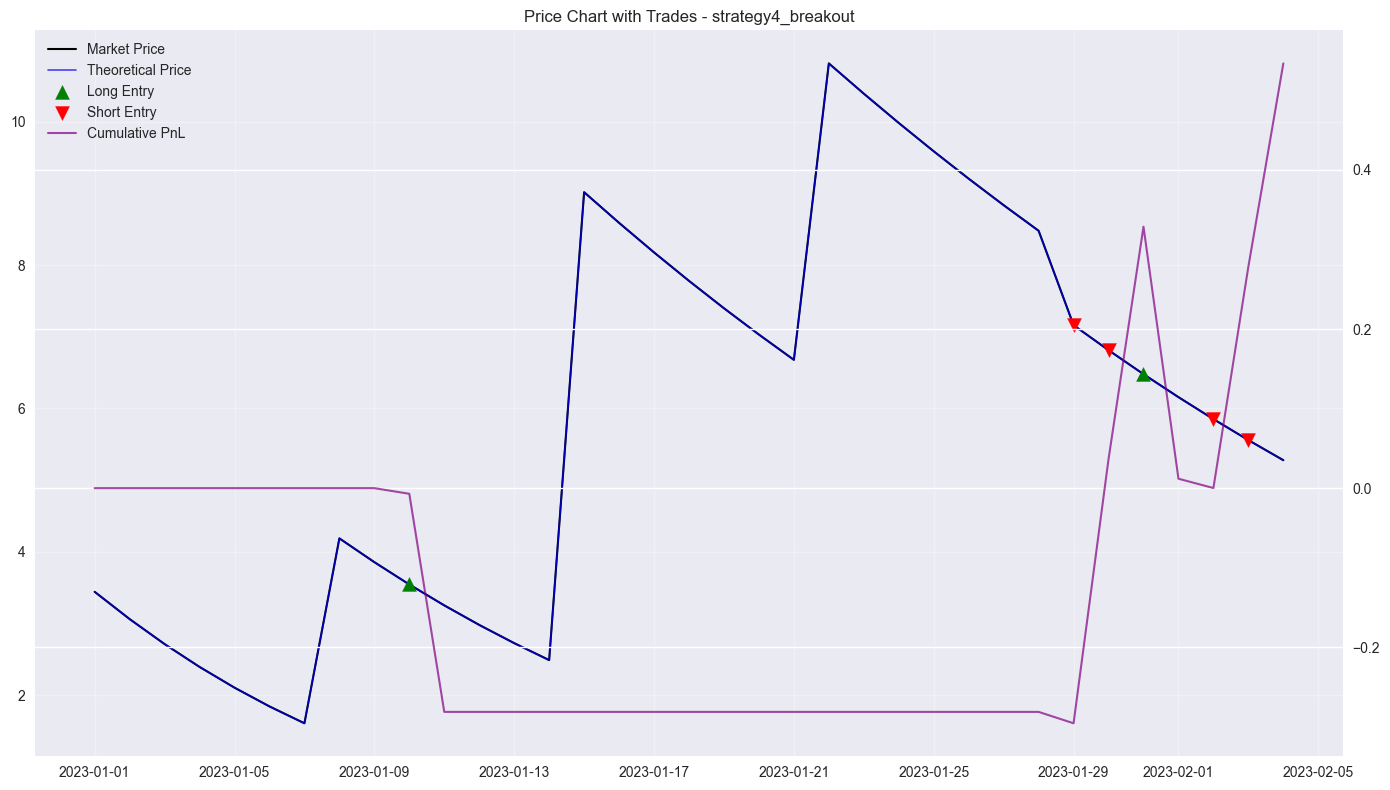

✓ Results saved to: /Users/amankesarwani/PycharmProjects/cso-lab/data/outputs/strategy4_breakout
Running sensitivity analysis for strategy4_breakout...
z=0.50, cost=0.0005 => Sharpe=-2.73
z=0.50, cost=0.0010 => Sharpe=3.04
z=0.50, cost=0.0020 => Sharpe=1.00
z=0.50, cost=0.0050 => Sharpe=-2.77
z=1.00, cost=0.0005 => Sharpe=-0.25
z=1.00, cost=0.0010 => Sharpe=3.00
z=1.00, cost=0.0020 => Sharpe=-2.40
z=1.00, cost=0.0050 => Sharpe=-2.79
z=1.50, cost=0.0005 => Sharpe=2.37
z=1.50, cost=0.0010 => Sharpe=-2.23
z=1.50, cost=0.0020 => Sharpe=2.87
z=1.50, cost=0.0050 => Sharpe=3.14
z=2.00, cost=0.0005 => Sharpe=0.74
z=2.00, cost=0.0010 => Sharpe=-0.65
z=2.00, cost=0.0020 => Sharpe=-0.46
z=2.00, cost=0.0050 => Sharpe=0.21
z=2.50, cost=0.0005 => Sharpe=1.84
z=2.50, cost=0.0010 => Sharpe=2.55
z=2.50, cost=0.0020 => Sharpe=0.67
z=2.50, cost=0.0050 => Sharpe=-3.01


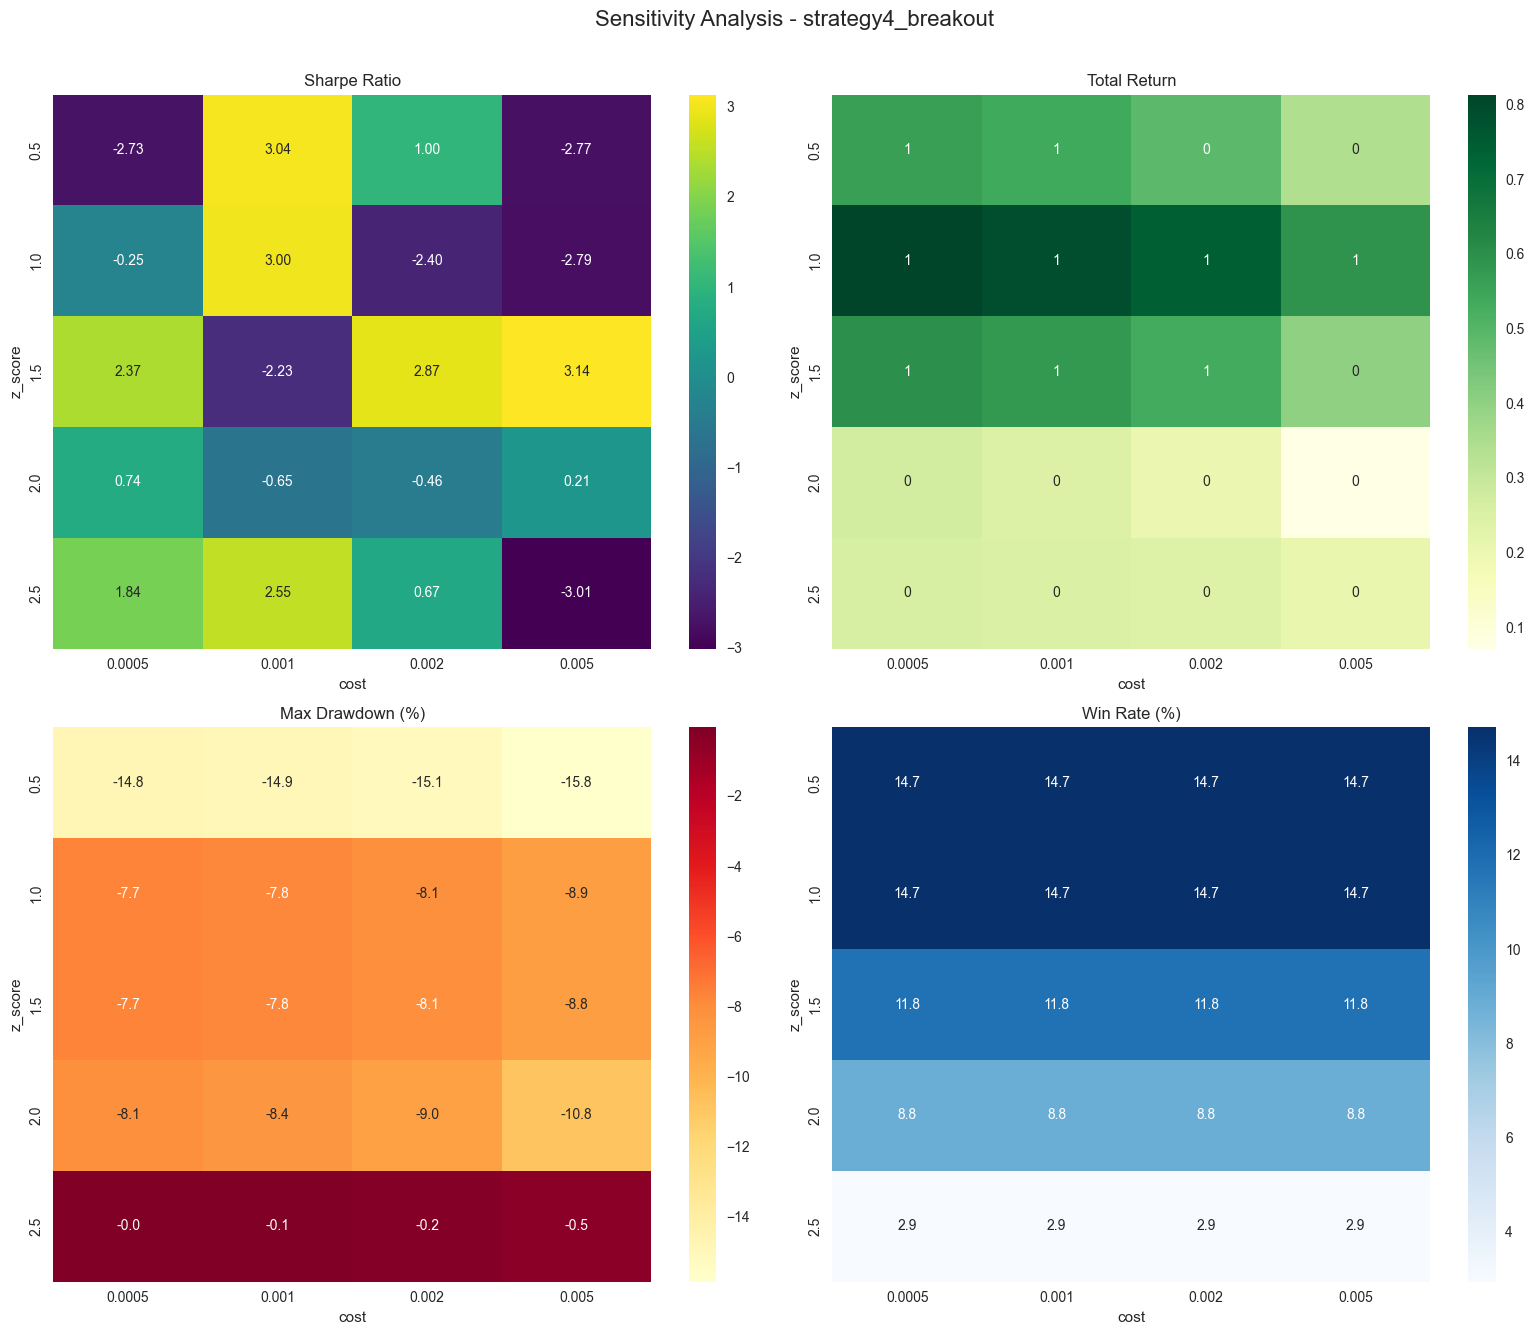

Completed strategy4_breakout


{'total_return': 0.5339256185354311,
 'total_return_pct': 15.509744970047015,
 'annualized_return': 0.378776932414894,
 'annualized_vol': 0.35678953489845633,
 'sharpe_ratio': 1.0616256794714996,
 'max_drawdown': -0.08059055605753218,
 'win_rate': 0.11764705882352941,
 'profit_factor': 1.3881172251899492,
 'num_trades': 3}

In [14]:
stats4 = run_single_strategy(
    strategy_name="strategy4_breakout",
    z_score=1.5,
    cost=0.002
)
stats4
